In [1]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [2]:
%cd /content/Drive/MyDrive/Sharif/Spring-1400/AIR/Project

/content/Drive/MyDrive/Sharif/Spring-1400/AIR/Project


# Community Detection

<html>
    <div style="direction:rtl;line-height:150%;" dir=rtl>
        <font face="B Nazanin" size=4>
           در این قسمت ابتدا تلاش داریم از خوشه‌بندی گراف برای دسته‌بندی داده‌ها استفاده کنیم. برای این منظور از امبدینگ‌های استفاده شده از بخش‌های قبلی استفاده کرده و برای هر سند برداری عددی فراهم می‌کنیم. (این کار در قسمت‌های قبلی انجام شده و در این مرحله مستقیما از آن‌ها استفاده می‌کنیم.)
           </br>
           سپس برای هر سند میزان شباهت‌ش را با سایر اسناد به کمک معیار شباهت کسینوسی محاسبه می‌کنیم. سپس گرافی از اسناد تهیه می‌کنیم که وزن یال میان هر دو سند میزان شباهت کسینوسی آن‌ها باشد.
           برای سادگی در محاسبات و نتایج بهتر، یال‌هایی که وزن کمی دارند را حذف کرده و گراف شباهت اسناد می‌رسیم.
           در ادامه از الگوریتم‌های معروف دسته‌بندی گراف همچون 
           leiden
           و
           infomap
           استفاده کرده و اسناد را دسته‌بندی می‌کنیم.
        </font>
    </div> 
</html>

## Install and Import Libraries

In [3]:
!pip install cdlib
!pip install infomap leidenalg wurlitzer

In [43]:
import pandas as pd
import numpy as np
from random import choices

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from networkx import from_numpy_matrix
from cdlib.algorithms import leiden, infomap

## Load Document Vectors

In [5]:
# data_df = pd.read_csv('DataFrames/transformer_vectors.csv', index_col=0)
data_df = pd.read_csv('DataFrames/fasttext_embedded.csv', index_col=0)
data_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
195528,-0.012402,-0.077719,-0.021008,0.022500,-0.010497,-0.058743,-0.004195,-0.127094,0.062188,-0.000435,...,-0.008159,-0.009081,-0.012941,-0.003692,0.010363,0.014501,-0.026796,0.005985,0.012650,-0.007647
195552,0.018970,-0.001358,-0.003685,-0.000681,-0.020905,0.005530,-0.016388,-0.210833,0.056330,-0.036689,...,-0.088736,-0.006603,0.002338,-0.019635,-0.003202,0.014979,0.013781,0.018346,-0.015892,0.025955
195602,-0.015543,-0.039430,0.024051,0.047467,-0.061052,-0.023567,0.012168,-0.038766,0.027427,-0.010946,...,-0.038852,0.033071,-0.090898,-0.044382,0.015452,0.020029,0.004593,0.012504,-0.012119,-0.003168
184150,0.038575,-0.005869,0.075760,-0.031768,-0.001228,-0.041842,0.053797,-0.142780,0.014443,-0.084863,...,-0.035328,0.018050,0.007826,0.009935,0.061012,0.026952,-0.053276,0.036215,0.049541,-0.005650
195652,-0.024282,-0.067053,0.035873,-0.020247,0.002273,-0.059648,-0.006990,-0.200828,0.078160,-0.006928,...,-0.048727,-0.019131,0.013508,-0.011488,0.025631,-0.000567,-0.023827,-0.000153,0.033275,0.009542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,-0.008621,-0.050148,0.004616,0.049542,-0.013963,-0.075733,0.040471,-0.176395,-0.019623,-0.017218,...,-0.035359,-0.031571,-0.030903,-0.032209,0.043427,0.020357,0.009014,-0.016637,-0.045678,-0.018780
17512,0.058859,-0.035017,0.034872,-0.000129,-0.002077,-0.045292,0.054486,-0.177909,-0.018674,-0.035403,...,-0.040811,0.020185,-0.006459,-0.050347,0.051230,0.002086,0.004679,-0.017196,0.003380,0.012391
17520,0.074162,-0.029601,0.016394,0.003039,-0.022986,-0.043504,-0.012015,-0.178004,-0.029245,-0.013844,...,-0.040048,-0.018998,0.014916,-0.052739,0.043571,0.000794,0.006100,-0.012305,0.003723,0.025204
17537,0.105391,-0.093249,0.062999,0.042043,-0.026794,-0.067085,0.037520,-0.101224,0.011941,0.038550,...,-0.137205,-0.004220,0.041103,-0.066300,0.097025,-0.005896,0.075072,-0.011595,0.050149,0.038464


In [6]:
X = data_df.values
ids = data_df.index.values

X.shape

(4339, 300)

In [13]:
# X_pca = PCA(n_components=100).fit_transform(X)

## Create Cosine Similarity Graph

In [7]:
cos_sim_matrix = cosine_similarity(X)

In [8]:
threshold = np.quantile(cos_sim_matrix, 0.85)
np.place(cos_sim_matrix, cos_sim_matrix < threshold, 0)

In [9]:
cos_graph = from_numpy_matrix(cos_sim_matrix)

## Cluster Graph and Find Communities

In [10]:
leiden_coms = leiden(cos_graph)

In [11]:
info_coms = infomap(cos_graph)

In [12]:
results = {
    'leiden':leiden_coms, 
    'infomap':info_coms
}

In [18]:
for coms_type, coms in results.items():
    print(coms_type)
    sizes = [len(coms.communities[i]) for i in range(len(coms.communities)) if len(coms.communities[i]) >= 100]
    print(len(coms.communities), len(sizes), sizes, f'coverage: {sum(sizes)/len(X)*100:.1f}%')

leiden
190 4 [1810, 897, 754, 548] coverage: 92.4%
infomap
247 5 [2802, 397, 350, 192, 109] coverage: 88.7%


<html>
    <div style="direction:rtl;line-height:150%;" dir=rtl>
        <font face="B Nazanin" size=3>
          نتایج بالا نشان می‌دهد در الگوریتم 
          infomap
          توانسته حدود ۸۹ درصد از اسناد را درگروه‌هایی با تعداد اعضای بیشتر از ۳ رقم قرار دهد. این الگوریتم بخش زیادی از اسناد (حدود ۵۰ درصد) را در یک گروه قرار داده و سایر دسته‌ها هر کدام حدود ۲ درصد از اسناد را در بر می‌گیرند. 
          اینگونه می‌توان برداشت کرد که این الگوریتم فضای مسئله ما را به یک گروه کلی و تعدادی گروه نامتعارف دسته‌بندی کرده است.
          </br>
          از طرف دیگر الگوریتم 
          leiden
          حدود 92 درصد از داده‌ها را در 4 دسته مختلف قرار دهد و سایر اسناد را درگروه‌های نامرتبط به آن دسته‌بندی کند. بنابراین می‌توان این ۸ درصد باقی‌مانده را به عنوان یک گروه نامتعارف درنظر گرفت در کنار ۴ انجمن شناسایی‌شده دیگر به یک خوشه‌بندی با ۵ دسته رسید.
        </font>
    </div> 
</html>

In [31]:
leiden_label = [None] * len(X)

for i, com in enumerate(leiden_coms.communities):
    label = i if len(com) >= 100 else -1
    for j in com:
        leiden_label[j] = label

In [32]:
info_label = [None] * len(X)

for i, com in enumerate(info_coms.communities):
    label = i if len(com) >= 100 else -1
    for j in com:
        info_label[j] = label

In [33]:
cluster_df = pd.DataFrame({
    'id': ids,
    'leiden_label': leiden_label, 
    'infomap_label': info_label
})
cluster_df

,id,leiden_label,infomap_label
0,195528,2,0
1,195552,0,0
2,195602,3,3
3,184150,-1,-1
4,195652,1,0
...,...,...,...
4334,4556,0,0
4335,17512,0,0
4336,17520,0,0
4337,17537,-1,-1


In [34]:
cluster_df.to_csv('DataFrames/communities.csv', index=False)

## Visualize Communities

In [27]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
x_tsne = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4339 samples in 0.002s...
[t-SNE] Computed neighbors for 4339 samples in 1.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4339
[t-SNE] Computed conditional probabilities for sample 2000 / 4339
[t-SNE] Computed conditional probabilities for sample 3000 / 4339
[t-SNE] Computed conditional probabilities for sample 4000 / 4339
[t-SNE] Computed conditional probabilities for sample 4339 / 4339
[t-SNE] Mean sigma: 0.127305
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.570000
[t-SNE] KL divergence after 1000 iterations: 1.859292


In [36]:
cluster_df['tsne-one'] = x_tsne[:, 0]
cluster_df['tsne-two'] = x_tsne[:, 1]

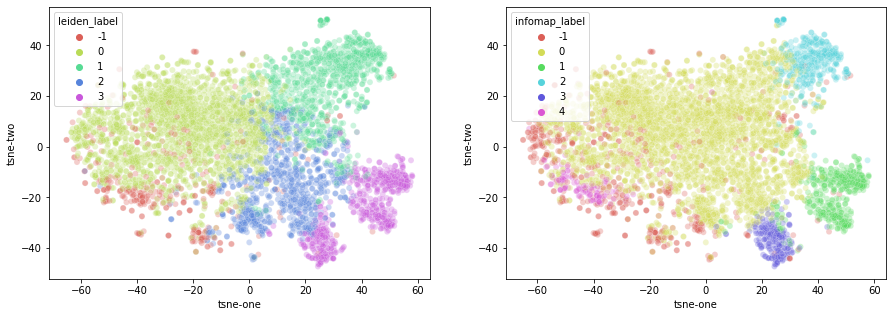

In [42]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.scatterplot(
        x = "tsne-one", y = "tsne-two",
        hue='leiden_label',
        palette=sns.color_palette("hls", cluster_df['leiden_label'].nunique()),
        data=cluster_df,
        legend='auto',
        alpha=0.3,
        ax=axs[0]
)

sns.scatterplot(
        x = "tsne-one", y = "tsne-two",
        hue='infomap_label',
        palette=sns.color_palette("hls", cluster_df['infomap_label'].nunique()),
        data=cluster_df,
        legend='auto',
        alpha=0.3,
        ax=axs[1]
)
plt.show()

## Sample Communities

In [44]:
sample_size = 5

In [53]:
summary_df = pd.read_csv('DataFrames/summary_df_raw.zip', index_col=0)

In [48]:
# leiden
leiden_sample = dict()
for c in cluster_df['leiden_label'].unique():
    leiden_sample[c] = choices(cluster_df['id'], k=sample_size)

In [59]:
for label, lst in leiden_sample.items():
    print('#' * 100)
    print('Cluster: ', label, '\n\n')
    for txt in summary_df.loc[lst]['Summary']:
        print(txt)
        print('-' * 50 + '\n')

####################################################################################################
Cluster:  2 


Dan Quillen was an American mathematician who won a Fields medal for his work in algebraic topology.
--------------------------------------------------

Vladimir Abramovich Rokhlin was a mathematician who was born in what is now Azerbaijan and worked in algebraic topology and geometry.
--------------------------------------------------

Henri René Pierre Villat (French: [vila]; 24 December 1879 – 19 March 1972) was a French mathematician. He was professor of fluid mechanics at the University of Paris since 1927. Villat became a member of the French Academy of Sciences in 1932, and its president in 1948.
--------------------------------------------------

Shahriar Shahriari (born May 30, 1956) is an American mathematician. He is the William Polk Russell Professor of Mathematics at Pomona College.
--------------------------------------------------

Bruce Lee Rothschild (bor

In [60]:
# infomap
info_sample = dict()
for c in cluster_df['infomap_label'].unique():
    info_sample[c] = choices(cluster_df['id'], k=sample_size)

In [61]:
for label, lst in info_sample.items():
    print('#' * 100)
    print('Cluster: ', label, '\n\n')
    for txt in summary_df.loc[lst]['Summary']:
        print(txt)
        print('-' * 50 + '\n')

####################################################################################################
Cluster:  0 


Michael Fekete was a Hungarian mathematician and set theorist who worked on the transfinite diameter of a set.
--------------------------------------------------

Mireille Bousquet-Mélou (born May 12, 1967) is a French mathematician who specializes in enumerative combinatorics and who works as a senior researcher for the Centre national de la recherche scientifique (CNRS) at the computer science department (LaBRI) of the University of Bordeaux.
--------------------------------------------------

Valérie Berthé (born 16 December 1968) is a French mathematician who works as a director of research for the Centre national de la recherche scientifique (CNRS) at the Institut de Recherche en Informatique Fondamentale (IRIF), a joint project between CNRS and Paris Diderot University. Her research involves symbolic dynamics, combinatorics on words, discrete geometry, numeral syste

# Topic Modeling

<html>
    <div style="direction:rtl;line-height:150%;" dir=rtl>
        <font face="B Nazanin" size=4>
           در این قسمت از 
           Topic Modeling
           و به صورت خاص الگوریتم 
           LDA
           برای دسته‌بندی موضوعی اسناد استفاده می‌کنیم.
           </br>
           در این الگوریتم لازم است اسناد را توکنایز کرده بر اساس مدل جعبه کلمات
           (bag of words)
           به صورت احتمالاتی دسته هر سند را مشخص کنیم. در این الگوریتم لازم است تعداد دسته‌های مدنظر به عنوان ورودی به مدل داده شود. با توجه به نتایج قسمت قبل انتظار داریم تعداد مناسب دسته‌ها چیزی حدود ۵ دسته باید باشد.
        </font>
    </div> 
</html>

## Install and Import libraires

In [ ]:
!pip install hazm pyLDAvis

In [66]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from gensim import corpora
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from gensim.models.phrases import Phraser

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import seaborn as sns
from matplotlib import pyplot as plt

## Load Data Tokens

In [65]:
data_df = pd.read_csv('DataFrames/summary_df.zip', index_col=0)
data_df

,Summary
195528,"['justin', 'wayne', 'jacob', 'born', 'c', '198..."
195552,"['alexander', 'schmidt', 'born', '1965', 'germ..."
195602,"['carl', 'wolfgang', 'benjamin', 'goldschmidt'..."
184150,"['xavier', 'ro', 'oton', 'barcelona', '1988', ..."
195652,"['athanassios', 'spyridon', 'fokas', 'greek', ..."
...,...
4556,"['richard', 'hamming', 'wa', 'american', 'math..."
17512,"['israil', 'gelfand', 'wa', 'ukranian', 'mathe..."
17520,"['anatoly', 'malcev', 'wa', 'russian', 'mathem..."
17537,"['yuri', 'prokhorov', 'wa', 'russian', 'mathem..."


In [67]:
ids = data_df.index.values
tokens = [eval(i) for i in tqdm(data_df['Summary'])]

100%|██████████| 4339/4339 [00:00<00:00, 7477.21it/s]


In [69]:
bigrams = Phrases(tokens, min_count=5, threshold=100)
bigram_mode = Phraser(bigrams)
bigram_tokens = [bigram_mode[i] for i in tqdm(tokens)]

100%|██████████| 4339/4339 [00:01<00:00, 3686.29it/s]


## Create Term-Document Matrix

In [70]:
id2word = corpora.Dictionary(bigram_tokens)
corpus = [id2word.doc2bow(text) for text in tqdm(bigram_tokens)]

100%|██████████| 4339/4339 [00:00<00:00, 7823.02it/s]


## Generate LDA Model

In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=5, passes=10)

In [72]:
lda_model.print_topics()

[(0,
  '0.028*"wa" + 0.027*"mathematician" + 0.010*"born" + 0.009*"german" + 0.006*"number" + 0.005*"field" + 0.005*"equation" + 0.005*"french" + 0.005*"american" + 0.005*"work"'),
 (1,
  '0.030*"wa" + 0.020*"mathematician" + 0.009*"theory" + 0.007*"known" + 0.007*"work" + 0.006*"problem" + 0.006*"german" + 0.005*"russian" + 0.004*"also" + 0.003*"method"'),
 (2,
  '0.073*"wa" + 0.071*"mathematician" + 0.041*"worked" + 0.039*"theory" + 0.014*"american" + 0.013*"geometry" + 0.011*"topology" + 0.010*"number" + 0.010*"contribution" + 0.009*"german"'),
 (3,
  '0.035*"wa" + 0.023*"mathematician" + 0.016*"american" + 0.010*"mathematical" + 0.007*"best_known" + 0.007*"mathematics" + 0.006*"work" + 0.006*"theory" + 0.006*"known" + 0.004*"worked"'),
 (4,
  '0.032*"university" + 0.023*"wa" + 0.018*"mathematics" + 0.018*"professor" + 0.013*"mathematician" + 0.011*"theory" + 0.010*"research" + 0.010*"mathematical" + 0.010*"science" + 0.009*"born"')]

## Visualize Topics

In [73]:
pyLDAvis.enable_notebook()

In [74]:
gensimvis.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.164750 -0.084851       1        1  63.694479
0      0.022704  0.039899       2        1  11.000356
2     -0.145253 -0.107529       3        1   9.501905
1     -0.010229  0.107144       4        1   8.813529
3     -0.031972  0.045337       5        1   6.989731, topic_info=              Term         Freq        Total Category  logprob  loglift
46              wa  5730.000000  5730.000000  Default  30.0000  30.0000
26   mathematician  4013.000000  4013.000000  Default  29.0000  29.0000
58          theory  2355.000000  2355.000000  Default  28.0000  28.0000
395         worked  1056.000000  1056.000000  Default  27.0000  27.0000
2         american  1187.000000  1187.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
80       physicist    22.071801   216.963240   Topic5  -6.4028   0.3753
304          first    24.207535   399.796333   Topic5  -6.3104  -0.1436
120       analysis    25.589658   614.403576   Topic5  -6.2549  -0.5177
753    probability    22.800013   271.550025   Topic5  -6.3703   0.1833
145        society    22.926120   464.395478   Topic5  -6.3648  -0.3477

[404 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
1237       2  0.899047    1896
217        1  0.994352    1987
746        1  0.523194      20
746        2  0.174398      20
746        3  0.021800      20
...      ...       ...     ...
216        2  0.030571    year
216        3  0.002779    year
216        4  0.044466    year
216        5  0.069479    year
15150      5  0.860111  zeeman

[774 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4])